# Sea Surface Temperatures Analysis

## Setup & Data Import

In [1]:
# Import required libraries
import warnings, numpy as np, pandas as pd, xarray as xr
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [2]:
# Load sea surface temp data
ERSST_PATH = './data/raw/ersst.v6.1850-2024.nc'
ds = xr.open_dataset(ERSST_PATH)
ds

<xarray.Dataset> Size: 269MB
Dimensions:  (lat: 89, lev: 1, lon: 180, time: 2100)
Coordinates:
  * lat      (lat) float64 712B -88.0 -86.0 -84.0 -82.0 ... 82.0 84.0 86.0 88.0
  * lev      (lev) float64 8B 0.0
  * lon      (lon) float64 1kB 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 17kB 1850-01-15 1850-02-15 ... 2024-12-15
Data variables:
    sst      (time, lev, lat, lon) float32 135MB ...
    ssta     (time, lev, lat, lon) float32 135MB ...
Attributes: (12/70)
    Conventions:                     CF-1.6, ACDD-1.3
    metadata_link:                   https://doi.org/10.7289/V5T72FNM
    dataset_doi:                     https://doi.org/10.7289/V5T72FNM
    id:                              gov.noaa.ncdc:C00927
    naming_authority:                gov.noaa.ncei
    title:                           NOAA ERSSTv6 (in situ only)
    ...                              ...
    references:                      Huang et al, 2023: A Data Update for Ext...
    climatology:                     Climatology is based on 1991-2020 SST of...
    acknowledgment:                  The NOAA Extended Reconstructed Sea Surf...
    history:                         Tue Jan 21 09:32:56 2025: ncap2 -O -s ti...
    NCO:                             netCDF Operators version 4.7.5 (Homepage...
    nco_openmp_thread_number:        1

## Data Wrangling

In [3]:
# Helper functions
def region_mask(da, lat_bounds, lon_bounds):
    lat_cond = (da.lat >= lat_bounds[0]) & (da.lat <= lat_bounds[1])
    def _wrap(l): return (l + 360) % 360
    lo, hi = map(_wrap, lon_bounds)
    lon_cond = (da.lon >= lo) & (da.lon <= hi) if lo <= hi else (da.lon >= lo)|(da.lon <= hi)
    return da.where(lat_cond & lon_cond, drop=True)

def area_weighted_mean(da):
    weights = np.cos(np.deg2rad(da.lat))
    return da.weighted(weights).mean(('lat', 'lon'))

# Region bounds
REGIONS = {
    'Global': None,
    'NHem': ((0, 90), (0, 360)),
    'SHem': ((-90, 0), (0, 360)),
    'Tropics': ((-20, 20), (0, 360)),
    'Pacific': ((-60, 60), (120, -70)),
    'Atlantic': ((-60, 60), (-70, 20)),
    'Indian': ((-30, 30), (20, 120))
}

In [4]:
# Inspection of missing data
missing_pct = ds['sst'].isnull().sum() / ds['sst'].size * 100
print(f"Percentage of missing values: {missing_pct:.2f}%")

Percentage of missing values: 30.87%


In [5]:
# Group by region and compute annual mean sea surface temp
ds['time'] = pd.to_datetime(ds['time'].values)
sst = ds['sst'].where(ds['sst'] != ds['sst'].encoding.get('_FillValue', np.nan))
annual = sst.groupby('time.year').mean('time', skipna=True)

def region_series(annual_da, region_name):
    if region_name == 'Global':
        return area_weighted_mean(annual_da).squeeze()
    lat_b, lon_b = REGIONS[region_name]
    return area_weighted_mean(region_mask(annual_da, lat_b, lon_b)).squeeze()

reg_ds = xr.Dataset({name: region_series(annual, name) for name in REGIONS})
annual_df = reg_ds.to_dataframe()
annual_df.head()

# Drop lev column
annual_df = annual_df.drop('lev', axis=1)

## Data Analysis

In [6]:
# Focus on 1980‑2024
period_df = annual_df.loc[1980:2024].copy()
period_df.head()

,Global,NHem,SHem,Tropics,Pacific,Atlantic,Indian
year,,,,,,,
1980,18.064883,15.558101,16.141844,24.566961,20.554832,18.418562,26.762499
1981,18.029512,15.529872,16.083428,24.703263,20.528222,18.374962,26.698618
1982,18.030472,15.437953,16.006341,24.464784,20.574484,18.304284,26.724694
1983,18.101853,15.523977,16.121264,24.635955,20.598630,18.402997,26.936795
1984,18.007018,15.735217,16.429750,25.243106,20.492300,18.406037,26.576726


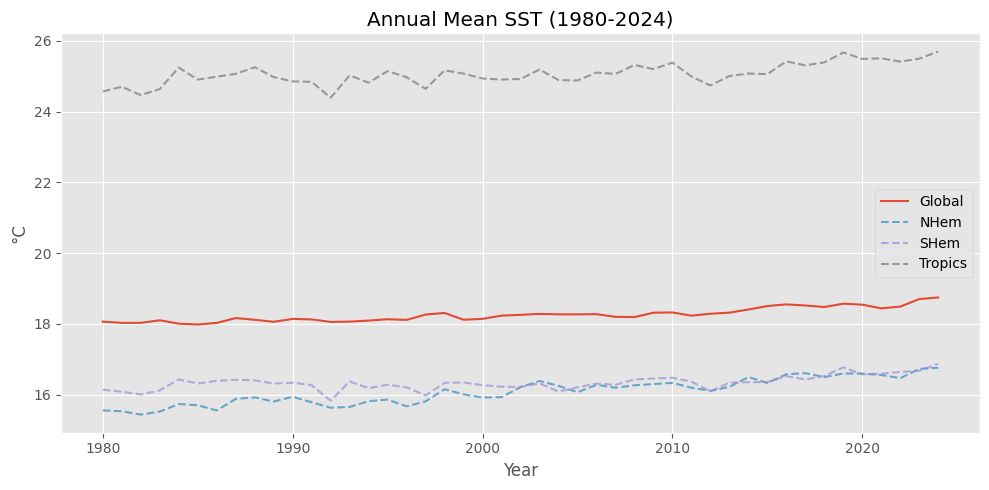

In [7]:
# Plot mean sea surface temp over time
fig, ax = plt.subplots(figsize=(10,5))
period_df['Global'].plot(ax=ax, label='Global')
for r in ['NHem', 'SHem', 'Tropics']:
    period_df[r].plot(ax=ax, linestyle='--', alpha=.7, label=r)
ax.set(title='Annual Mean SST (1980‑2024)', xlabel='Year', ylabel='°C')
ax.legend(); plt.tight_layout(); plt.show()

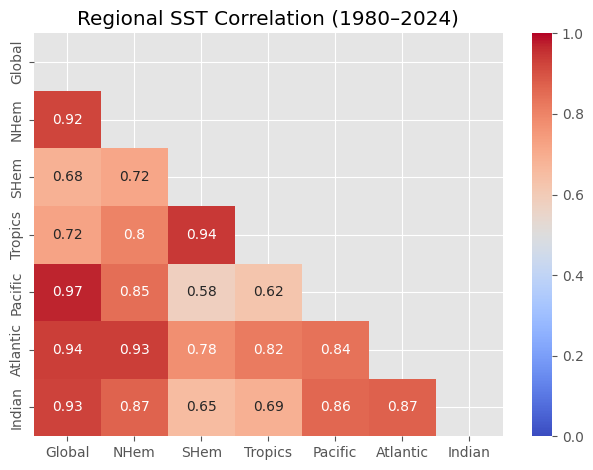

In [8]:
# Correlation heatmap
corr = period_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, vmin=0, vmax=1, cmap='coolwarm')
plt.title('Regional SST Correlation (1980–2024)')
plt.tight_layout()
plt.show()

### Regression

,°C/decade
NHem,0.263735
Atlantic,0.173652
Tropics,0.163375
Indian,0.155528
Global,0.134042
Pacific,0.130686
SHem,0.097835


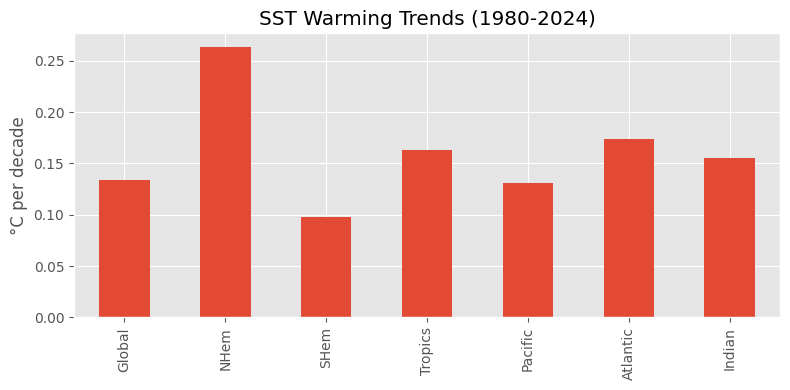

In [9]:
# Linear trend per region
trend = {}
for region, ser in period_df.items():
    ser = ser.dropna()
    if len(ser) < 5:
        continue
    slope = LinearRegression().fit(ser.index.values.reshape(-1,1), ser.values).coef_[0]*10
    trend[region] = slope
trend_df = pd.Series(trend, name='°C/decade').to_frame()
display(trend_df.sort_values('°C/decade', ascending=False))

# Plot warming trends as bar plot
trend_df.plot(kind='bar', legend=False, figsize=(8,4))
plt.ylabel('°C per decade'); plt.title('SST Warming Trends (1980‑2024)')
plt.tight_layout(); plt.show()


### Clustering

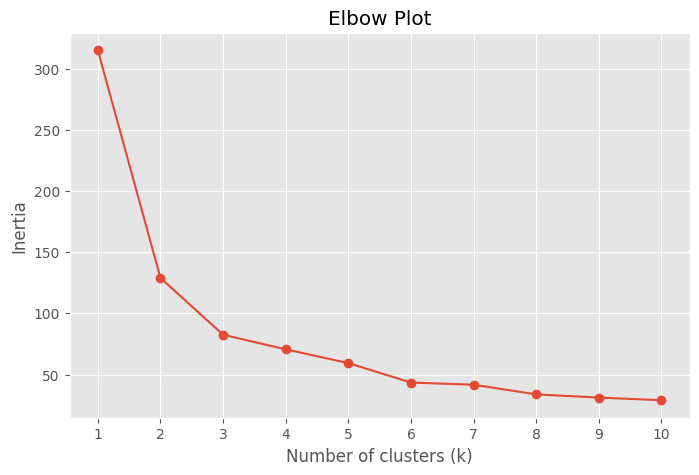

In [10]:
# Standardise features
X = StandardScaler().fit_transform(period_df)

# Elbow method
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Plot')
plt.xticks(k_range)
plt.grid(True)
plt.show()

# Cluster using KMeans
k_optimal = 3
kmeans = KMeans(n_clusters=k_optimal, random_state=0).fit(X)
period_df['cluster'] = kmeans.labels_

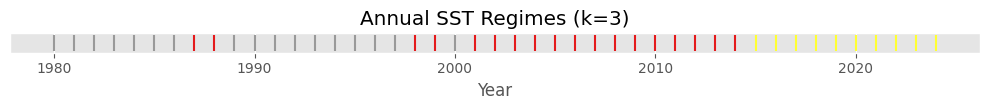

In [11]:
# Plot clusters on timeline
fig, ax = plt.subplots(figsize=(10,1.2))
ax.scatter(period_df.index, [0]*len(period_df), c=period_df['cluster'],
           cmap=plt.cm.get_cmap('Set1', k), s=120, marker='|')
ax.set_yticks([]); ax.set_xlabel('Year')
ax.set_title('Annual SST Regimes (k=3)')
plt.tight_layout(); plt.show()

In [12]:
# Display cluster centers
centers = pd.DataFrame(StandardScaler().fit(period_df.drop(columns='cluster')).inverse_transform(kmeans.cluster_centers_),
                       columns=period_df.columns.drop('cluster'))
centers.index = [f'Cluster {i}' for i in range(k_optimal)]
centers


,Global,NHem,SHem,Tropics,Pacific,Atlantic,Indian
Cluster 0,18.254028,16.178576,16.315845,25.067512,20.709388,18.704011,27.037604
Cluster 1,18.554544,16.571947,16.596325,25.444246,21.059361,19.013663,27.320514
Cluster 2,18.084772,15.702199,16.207995,24.829063,20.592234,18.429444,26.750717


In [13]:
# Save processed dat
annual_df.to_csv('./data/processed/sst_means.csv')
period_df.to_csv('./data/processed/sst_clusters.csv')
trend_df.to_csv('./data/processed/sst_trends.csv')